# Suave basic usage

Here we demonstrate the basic usage of the estimator by computing a continuous correlation function using a spline basis.

Load in a data catalog (in a periodic cube) and generate a random catalog. Note that we are making our random 3x the size of the data so we can compute this in a reasonable amount of time, but in reality you'd want a larger factor.

In [1]:
import numpy as np
from Corrfunc import bases, theory, utils, io

boxsize = 750.0
x, y, z = io.read_lognormal_catalog(n='2e-4')
nd = len(x)
nr = 3*nd
np.random.seed(42)
x_rand = np.random.uniform(0, boxsize, nr)
y_rand = np.random.uniform(0, boxsize, nr)
z_rand = np.random.uniform(0, boxsize, nr)

To use the spline basis, set `proj_type = general_r`, which is the general mode for reading an r-dependent basis from a file. Then use the `spline_bases` helper function to write the bases to a file:

In [2]:
proj_type = 'generalr'
kwargs = {'order': 3}
projfn = 'cubic_spline.dat'
rmin, rmax, ncomponents = 40.0, 152.0, 14
bases = bases.spline_bases(rmin, rmax, projfn, ncomponents, ncont=2000, **kwargs)

To compute the full 3D correlation function, we can use the 2D correlation function DD(s, $\mu$) with a single all-encompassing $\mu$ bin. We use the `DDsmu` routine to compute the projection vectors v_DD, v_DR, and v_RR, and the projection tensor T_RR. Note that the DR and RR terms take a while to compute (order ~minutes for this notebook); we hope to speed these all up in an upcoming version of suave.

In [3]:
r_edges = np.linspace(rmin, rmax, ncomponents+1)
nmubins = 1
mumax = 1.0
periodic = True
nthreads = 2

dd_res, dd_proj, _ = theory.DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                                  boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                                  ncomponents=ncomponents, projfn=projfn)
dr_res, dr_proj, _ = theory.DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, 
                                  X2=x_rand, Y2=y_rand, Z2=z_rand, 
                                  boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                                  ncomponents=ncomponents, projfn=projfn)
rr_res, rr_proj, trr_proj = theory.DDsmu(1, nthreads, r_edges, mumax, nmubins, 
                                         x_rand, y_rand, z_rand, boxsize=boxsize,
                                         periodic=periodic, proj_type=proj_type,
                                         ncomponents=ncomponents, projfn=projfn)

From the projection vectors, we can compute the *amplitudes* with `compute_amps`, which uses a generalization of Landy-Szalay. We can then evaluate the correlation function on a fine r-grid with `evaluate_xi`:  

In [4]:
amps = utils.compute_amps(ncomponents, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, trr_proj)
r_fine = np.linspace(rmin, rmax, 2000)
xi_proj = utils.evaluate_xi(amps, r_fine, proj_type, projfn=projfn)

Let's plot the results, comparing to the standard binned estimator (grey dots). We can see that the spline basis produced a smooth, continuous correlation function (thick red line) that is a linear combination of the basis functions (thin dark red lines).

In [5]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

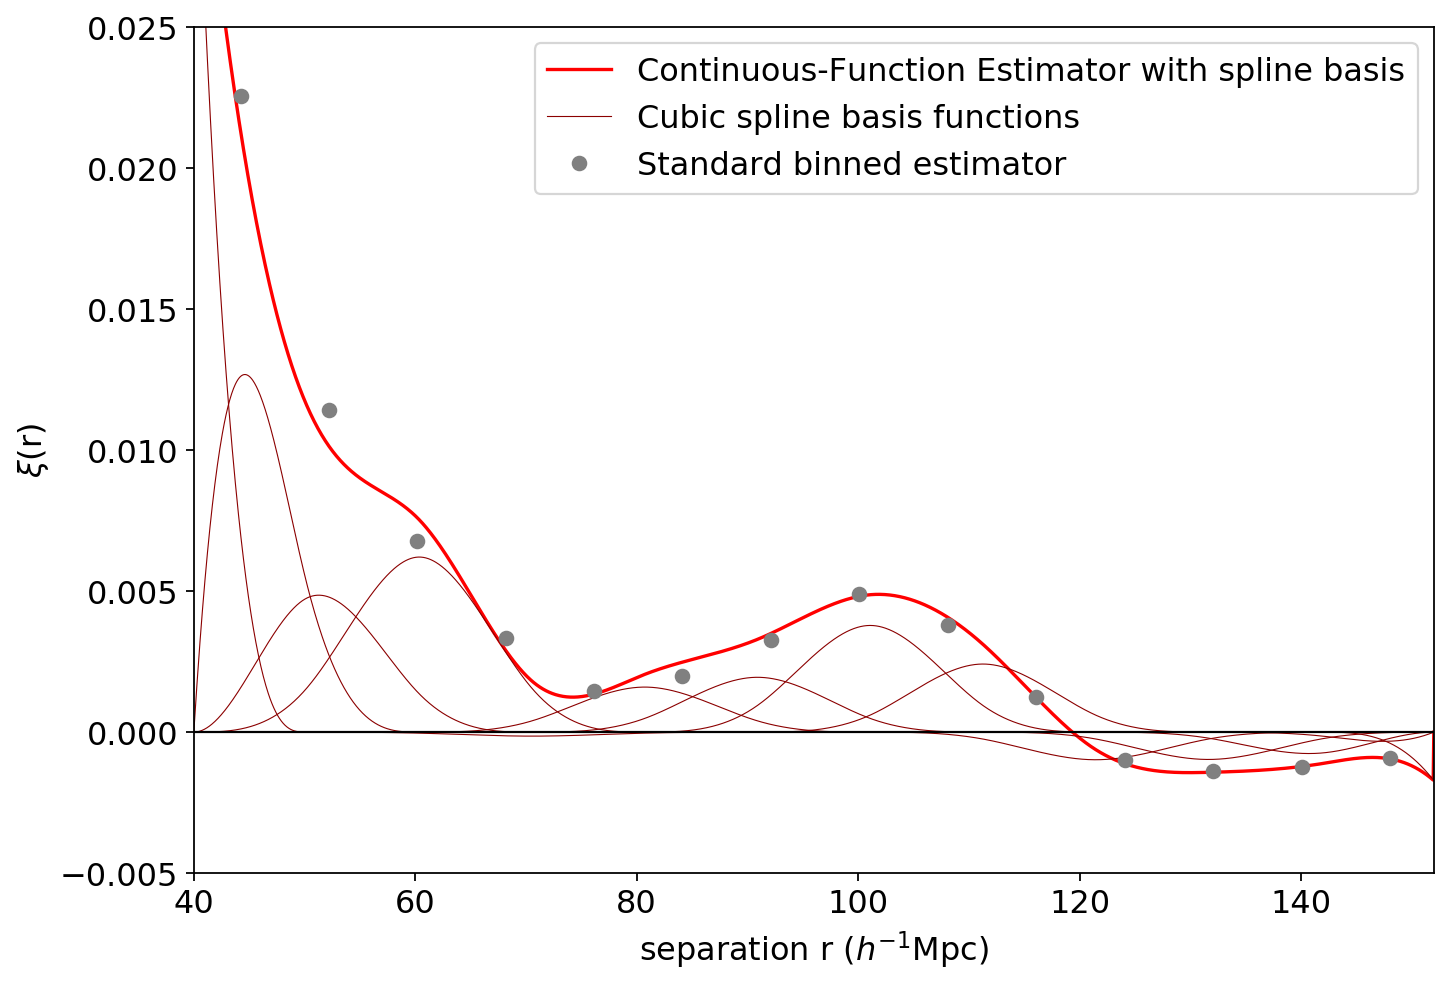

In [6]:
from matplotlib import pyplot as plt

xi_res = theory.xi(boxsize, nthreads, r_edges, x, y, z, output_ravg=True)
r_avg, xi_standard = xi_res['ravg'], xi_res['xi']

plt.figure(figsize=(10,7))
plt.plot(r_fine, xi_proj, color='red', lw=1.5, label='Continuous-Function Estimator with spline basis')

r = bases[:,0]
base_vals = bases[:,1:]
for i in range(base_vals.shape[1]):
    label = None
    if i==0:
        label = 'Cubic spline basis functions'
    plt.plot(r, amps[i]*base_vals[:,i], color='darkred', lw=0.5, label=label)
    
plt.plot(r_avg, xi_standard, marker='o', ls='None', color='grey', label='Standard binned estimator')

plt.axhline(0.0, color='k', lw=1)
plt.xlim(min(r), max(r))
plt.ylim(-0.005, 0.025)
plt.xlabel(r'separation r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()
plt.savefig('spline_example.png')

Finally, remember to clean up the basis function file:

In [8]:
import os
os.remove(projfn)